# PyTorch:  Neural Network for Multiclass Classification

## Toy data

Consider a two-dimensional feature space. There are objects of three kinds (classification into three classes).<br>
Let's generate 1200 objects and draw them in the feature space.
For training data, Y must contain an integer - the class number!

X: torch.Size([1200, 2]) Y: torch.Size([1200, 2])
tensor([0.4763, 0.1696]) 2
tensor([0.8959, 0.8912]) 2
tensor([0.0297, 0.9944]) 2
tensor([0.6646, 0.0981]) 0
tensor([0.3082, 0.1381]) 2
tensor([0.7460, 0.2732]) 0
tensor([0.0011, 0.5438]) 2
tensor([0.5689, 0.4543]) 0
tensor([0.2951, 0.6071]) 1
tensor([0.3187, 0.7246]) 1


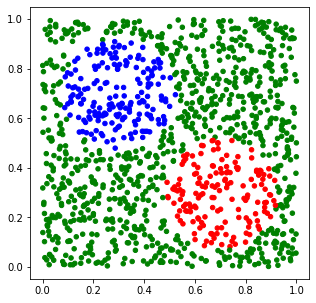

In [48]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt  
from matplotlib import colors

X = torch.rand (1200,2)                       
C1 = (torch.sum((X - torch.tensor([0.7, 0.3]))**2, axis=1) < 0.05).float().view(-1,1)
C2 = (torch.sum((X - torch.tensor([0.3, 0.7]))**2, axis=1) < 0.05).float().view(-1,1)
C3 = (C1 * C2 == 0).float().view(-1,1)

Y = torch.argmax(torch.cat([C1,C2,C3], 1), 1)

print("X:", X.shape, "Y:", X.shape)
for i in range(10):
    print(X[i], Y[i].item())
 
plt.figure (figsize=(5, 5)) 
cmap = colors.ListedColormap(['red', 'blue', 'green'])
plt.scatter(X.numpy()[:,0], X.numpy()[:,1], c=Y.numpy(),  s=20, cmap=cmap)        
plt.show()                                                  

## Network

The three outputs of the network correspond to the probabilities of each of the three classes.
Since we use the `CrossEntropyLoss`, there is no need to set the `softmax` function at the network output!!!
$$
\mathrm{CrossEntropyLoss}(y, c) = -\,w_c\,\log\left( \frac{\exp {y_{ic}}}{ \sum_\alpha \exp{y_{i\alpha}}}\right).
$$

In [33]:
nX, nH, nY = 2, [5,7], 3
 
model = nn.Sequential(
          nn.Linear(nX, nH[0]), 
          nn.Sigmoid(),  
          nn.Linear(nH[0], nH[1]), 
          nn.Sigmoid(),   
          nn.Linear(nH[1], nY) )  

gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model.to(gpu)
X = X.to(gpu)
Y = Y.to(gpu)

print(gpu)

cuda:0


## Network learning


In [34]:
loss      = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.5, momentum=0.8)   

In [35]:
def fit(model, X,Y, batch_size=1000, train=True):          
    model.train(train)                                 # важно для Dropout, BatchNorm
    sumL, sumA, numB = 0, 0, int( len(X)/batch_size )  # ошибка, точность, батчей
       
    idx = torch.randperm( len(X) ).to(gpu)             # перемешанный список индексов
    X, Y = X[idx], Y[idx]      

    for i in range(0, numB*batch_size, batch_size):          
        xb = X[i: i+batch_size]                         # текущий батч,
        yb = Y[i: i+batch_size]                         # X,Y - torch тензоры         
              
        y = model(xb)                                   # прямое распространение
        L = loss(y, yb)                                 # вычисляем ошибку
  
        if train:                                       # в режиме обучения
            optimizer.zero_grad()                       # обнуляем градиенты        
            L.backward()                                # вычисляем градиенты            
            optimizer.step()                            # подправляем параметры
                                     
        sumL += L.detach().item()                       # суммарная ошибка (item из графа)
        
        a = 
        sumA += (a == yb).float().mean()       # точность определения класса
         
    return sumL/numB,  sumA/numB                     # средняя ошибка и точность


In [38]:
import time
model.to(gpu)
print( "before:      loss: %.3e accuracy: %.4f" %  fit(model, X,Y, train=False) )
 
beg = time.process_time()
epochs = 10000                                            # число эпох
for epoch in range(epochs):                              # эпоха - проход по всем примерам
    L,A = fit(model, X, Y, batch_size=1000)              # одна эпоха
      
    if (epoch and epoch % 100 == 0) or epoch == epochs-1:  
        print(f"\repoch: {epoch:5d} loss: {L:.3e} accuracy: {A:.4f}   {time.process_time()-beg:.2f}s", end="")   
        beg = time.process_time()

before:      loss: 1.076e-02 accuracy: 0.9990
epoch:  9999 loss: 1.058e-02 accuracy: 0.9980   0.12s

## Classification visualization

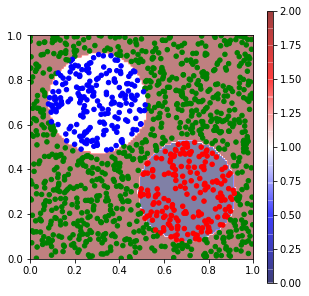

In [47]:
X_MIN, X_MAX, X_NUM = 0., 1., 100
Y_MIN, Y_MAX, Y_NUM = 0., 1., 100

x = np.linspace(X_MIN, X_MAX, X_NUM, dtype=np.float32)
y = np.linspace(Y_MIN, Y_MAX, Y_NUM, dtype=np.float32)
x, y =  np.meshgrid(x, y)    

inp = torch.cat([torch.tensor(x).view(-1,1), torch.tensor(y).view(-1,1)], 1)

z = model(inp.to(gpu)).detach().to('cpu')
z = torch.argmax( torch.softmax(z, 1), 1 ).view(X_NUM, Y_NUM)
    
plt.figure(figsize=(5,5))
plt.imshow(z, extent=[X_MIN, X_MAX, Y_MIN, Y_MAX],  origin='lower', cmap='seismic', alpha=0.5)
plt.colorbar(aspect=50) 
cmap = colors.ListedColormap(['red', 'blue', 'green'])
plt.scatter(X.cpu().numpy()[:,0], X.cpu().numpy()[:,1], c=Y.cpu().numpy(),  s=20, cmap=cmap)       

plt.show()